In [8]:
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
from tqdm import tqdm_notebook as tqdmn
tqdm.pandas()
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload

from utils.ReviewFeatureExtractor import ExtractBoW

### Hyperparameters

In [2]:
VOC_SIZE = 100000
REVIEW_CUTOFF_DATE = pd.Timestamp(2015, 12, 31)

### All Words

In [3]:
e = ExtractBoW(voc_size=VOC_SIZE)

e.load_word_vecs('../data/wiki-news-300d-1M.vec')

### Need to iterate through each business and person

In [4]:
df_reviews = pd.read_pickle('univ/tor_reviews.p')  # reviews
df_reviews['date'] = df_reviews['date'].astype('datetime64[ns]')
df_bus = pd.read_pickle('univ/tor_rest.p')  # businesses
df_users = pd.read_pickle('univ/tor_users.p')  # users

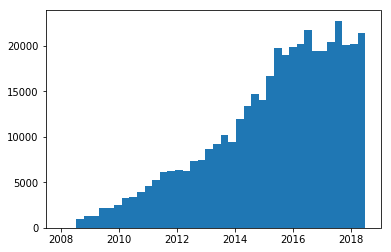

In [11]:
plt.hist(df_reviews['date'].values, bins=40)
plt.show()

### Loop Through the Reviews, and Create the Vectors for each review

In [5]:
df_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,f5O7v_X_jCg2itqacRfxhg,0,2017-10-12,0,kS4hrhEScwB9V5JATYjvVQ,5,Sansotei serves some top notch ramen. They tak...,0,hxqo4NyJFfeOmuoVi--s1A
1,Edr6SafmQrZa6CcFuItoqg,0,2014-06-03,0,U04YgYr4PiGUxB46J4xapg,2,Limited vegetarian options. Ordered Greek sala...,0,B7Fh30KQT1xPSGt_pIhRRA
2,7xA6iSP0Ndn08tpBFQtUKA,0,2017-05-22,0,YDJDfKnx6VpMMo4EBxycGg,1,Non-existened service! The waiter did not eve...,0,FCtoTo9zSH1cSAkascfEHw
3,SmizR7MLt-558FJJQRBBoQ,1,2011-06-01,1,2Hk7DNwu3rb2jKHaFfPyCA,4,It might be a bit unfair to review Globe so ea...,1,YHWsLBS8jzZiPjKHMFOaAA
4,iKMLsX1Je7P3wAOEc9scDg,0,2011-11-07,0,D2TcNaPqXxDGQ6T0n-vHXw,4,I have been itching to get to Origin for month...,4,YHWsLBS8jzZiPjKHMFOaAA


### Would apply work better?

In [10]:
tqdm.pandas(desc="vectorizing reviews")

In [11]:
def extract_vec_all(text):
    cur_vec = np.zeros(e.loaded_embeddings.shape[1])
    cur_token_dict = {}
    cur_tdict_n = {}
    cur_tdict_j = {}
    cur_tdict_v = {}
    
    for token, tag in nltk.pos_tag(nltk.word_tokenize(text)):
        if token in e.token2id:
            if token in cur_token_dict:
                cur_token_dict[token] += 1
            else:
                cur_token_dict[token] = 1
                
            if token in cur_tdict_n and tag[0] == e.WORD_TYPE_NOUN:
                cur_tdict_n[token] += 1
            else:
                cur_tdict_n[token] = 1
                
            if token in cur_tdict_j and tag[0] == e.WORD_TYPE_ADJ:
                cur_tdict_j[token] += 1
            else:
                cur_tdict_j[token] = 1
                
            if token in cur_tdict_v and tag[0] == e.WORD_TYPE_VERB:
                cur_tdict_v[token] += 1
            else:
                cur_tdict_v[token] = 1
                
                
    # all vocab
    cur_vec_weight = 0
    for cur_token in cur_token_dict.keys():
        cur_id = e.token2id[cur_token]
        cur_vec += e.loaded_embeddings[cur_id] * np.log(cur_token_dict[cur_token])
        cur_vec_weight += np.log(cur_token_dict[cur_token])
    
    if cur_vec_weight > 0:
        s1 = cur_vec / cur_vec_weight
    else:
        s1 = np.zeros(e.loaded_embeddings.shape[1])
        
    # nouns
    cur_vec_weight = 0
    for cur_token in cur_tdict_n.keys():
        cur_id = e.token2id[cur_token]
        cur_vec += e.loaded_embeddings[cur_id] * np.log(cur_tdict_n[cur_token])
        cur_vec_weight += np.log(cur_tdict_n[cur_token])
    
    if cur_vec_weight > 0:
        s2 = cur_vec / cur_vec_weight
    else:
        s2 = np.zeros(e.loaded_embeddings.shape[1])
        
    # adjectives
    cur_vec_weight = 0
    for cur_token in cur_tdict_j.keys():
        cur_id = e.token2id[cur_token]
        cur_vec += e.loaded_embeddings[cur_id] * np.log(cur_tdict_j[cur_token])
        cur_vec_weight += np.log(cur_tdict_j[cur_token])
    
    if cur_vec_weight > 0:
        s3 = cur_vec / cur_vec_weight
    else:
        s3 = np.zeros(e.loaded_embeddings.shape[1])
        
    # verbs
    cur_vec_weight = 0
    for cur_token in cur_tdict_v.keys():
        cur_id = e.token2id[cur_token]
        cur_vec += e.loaded_embeddings[cur_id] * np.log(cur_tdict_v[cur_token])
        cur_vec_weight += np.log(cur_tdict_v[cur_token])
    
    if cur_vec_weight > 0:
        s4 = cur_vec / cur_vec_weight
    else:
        s4 = np.zeros(e.loaded_embeddings.shape[1])
        
    return pd.Series([s1, s2, s3, s4], index=['all', 'noun', 'adj', 'verb'])

In [12]:
df_right = df_reviews['text'].progress_apply(extract_vec_all)

In [13]:
df_rev_out = pd.concat([df_reviews, df_right], axis=1)

### Group by the business and the users to get bus/user level vectors

In [14]:
df_rev_out.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id', 'all', 'noun', 'adj', 'verb'],
      dtype='object')

In [15]:
df_rev_out.to_pickle('features/wip_vec_reviews.p')

## Sorting and using the date field as index

In [17]:
df_rev_out['date'] = df_rev_out['date'].astype(np.datetime64)

#### Business

In [29]:
df_bus_sums = df_rev_out[['business_id', 
                          'all', 
                          'noun', 
                          'adj', 
                          'verb']].groupby('business_id').sum()

In [31]:
df_bus_counts = df_rev_out[['business_id', 'review_id']].groupby('business_id').count()

In [32]:
df_bus = df_bus_counts.join(df_bus_sums)
df_bus.rename(columns={'review_id': 'count'}, inplace=True)
df_bus.head()

,count,all,noun,adj,verb
business_id,,,,,
--DaPTJW3-tB1vP-PfdTEg,45,"[0.0017869004761138958, 0.20606939583017655, -...","[-0.11127622118822492, 2.8331555361971263, -6....","[-3.9484768743305056, 5.604928961798239, -12.7...","[0.4033316999024096, 3.265669911393346, -10.09..."
--SrzpvFLwP_YFwB_Cetow,44,"[-0.1029952507002102, 0.600745486661129, -1.08...","[-4.403267627244141, 10.240320037738009, -10.5...","[-8.638763987409279, 11.781320318543989, -15.6...","[-3.537699646974465, 7.744853670856408, -11.29..."
--lZAZSwpP_axKoL4lR9dQ,3,"[-0.004571479044457299, 0.002964029669554137, ...","[-0.13009907937042337, 0.01820574526766422, -1...","[-0.03153662383604755, 0.1709861428751057, -1....","[0.06465771962707753, -0.0835312185366967, -1...."
-0CCHBui57tZ_1y_14X-5Q,6,"[0.016851474460507318, 0.032703879528605845, -...","[-0.43303546292649403, 0.3393362473861706, -0....","[-0.053719300697059186, 0.4966665354190897, 0....","[0.19229890639646735, 0.1390788395194723, -0.0..."
-0CTrPQNiSyClxhdO4HSDQ,21,"[0.18496462294124774, 0.2902057050800089, -0.4...","[0.6698633493406726, 2.5049923458536396, -2.02...","[-1.7338338836213187, 9.772342803271602, -10.1...","[1.0441675078805337, 3.336597801476677, -3.847..."


In [73]:
df_bus.shape

(10914, 5)

#### User

In [33]:
df_user_sums = df_rev_out[['user_id', 
                           'all', 
                           'noun', 
                           'adj', 
                           'verb']].groupby('user_id').sum()

In [34]:
df_user_counts = df_rev_out[['user_id', 'review_id']].groupby('user_id').count()

In [35]:
df_user = df_user_counts.join(df_user_sums)
df_user.rename(columns={'review_id': 'count'}, inplace=True)
df_user.head()

,count,all,noun,adj,verb
user_id,,,,,
--56y1InAvNoQOD6YYrhVQ,1,"[0.016496436279152548, 0.036148138177207335, -...","[0.13578705018935083, 0.4624610821761501, -0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.28746848421468774, 0.6009304867712244, -0.3..."
--7gjElmOrthETJ8XqzMBw,2,"[0.04204776201754973, 0.012902529560547629, -0...","[0.6532981162577021, 0.35451768018026714, -0.6...","[0.28481480750402416, 0.22200113641187763, -0....","[0.4862463697378471, 0.08892722908663878, -0.5..."
--Br-QsbO9ad5GbZxVGxaw,1,"[-0.001990947646696029, 0.028539195695950172, ...","[-0.03228909115741223, 0.29352549830992447, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0041930276205179315, 0.3758376084920165, 0...."
--BumyUHiO_7YsHurb9Hkw,42,"[-0.22782512548218226, 0.5190823070811869, -1....","[-2.612504719725433, 6.863337608346825, -11.18...","[-2.627411829495066, 4.859770144849242, -12.32...","[-0.07258286541616335, 5.019621099363732, -12...."
--C93xIlmjtgQfSOIpcQSA,1,"[-0.012266972830970245, 0.038082180428604666, ...","[-0.19651541564104572, 0.3688580538162743, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [36]:
df_users.shape

(93075, 21)

### Finally loop through the reviews database and compute the ex-current bus and user vectors, then compute cosine similarity

In [37]:
df_m1 = df_rev_out.merge(df_user.reset_index(), how='left', on='user_id', suffixes=('', '_u'))

In [38]:
df_m2 = df_m1.merge(df_bus.reset_index(), how='left', on='business_id', suffixes=('', '_b'))

In [39]:
df_m2.shape

(422790, 23)

In [40]:
df_m2.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id', 'all', 'noun', 'adj', 'verb', 'count', 'all_u',
       'noun_u', 'adj_u', 'verb_u', 'count_b', 'all_b', 'noun_b', 'adj_b',
       'verb_b'],
      dtype='object')

In [41]:
df_m2['all_ux'] = df_m2['all_u'] - df_m2['all']
df_m2['noun_ux'] = df_m2['noun_u'] - df_m2['noun']
df_m2['adj_ux'] = df_m2['adj_u'] - df_m2['adj']
df_m2['verb_ux'] = df_m2['verb_u'] - df_m2['verb']

df_m2['all_bx'] = df_m2['all_b'] - df_m2['all']
df_m2['noun_bx'] = df_m2['noun_b'] - df_m2['noun']
df_m2['adj_bx'] = df_m2['adj_b'] - df_m2['adj']
df_m2['verb_bx'] = df_m2['verb_b'] - df_m2['verb']

### for anything with just 1 count, the numerators will be zero anyway, okay to just add 1 to the count in those cases to use division after (prevents div by zero)

In [42]:
df_m2['count'] = df_m2['count'].apply(lambda x: x + 1 if x == 1 else x)
df_m2['count_b'] = df_m2['count_b'].apply(lambda x: x + 1 if x == 1 else x)

In [43]:
# get the average vectors:
df_m2['all_ux'] = df_m2['all_ux'] / df_m2['count']
df_m2['noun_ux'] = df_m2['noun_ux'] / df_m2['count']
df_m2['adj_ux'] = df_m2['adj_ux'] / df_m2['count']
df_m2['verb_ux'] = df_m2['verb_ux'] / df_m2['count']

df_m2['all_bx'] = df_m2['all_bx'] / df_m2['count_b']
df_m2['noun_bx'] = df_m2['noun_bx'] / df_m2['count_b']
df_m2['adj_bx'] = df_m2['adj_bx'] / df_m2['count_b']
df_m2['verb_bx'] = df_m2['verb_bx'] / df_m2['count_b']

In [44]:
def cs_all(row):
    return cos_sim(row['all_ux'], row['all_bx'])

def cs_noun(row):
    return cos_sim(row['noun_ux'], row['noun_bx'])

def cs_adj(row):
    return cos_sim(row['adj_ux'], row['adj_bx'])

def cs_verb(row):
    return cos_sim(row['verb_ux'], row['verb_bx'])

def cos_sim(a, b):
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    
    if norma > 0 and normb > 0:
        return a.dot(b) / (norma * normb)
    else:
        return np.NaN

df_m2['cos_sim_all'] = df_m2.progress_apply(cs_all, axis=1)
df_m2['cos_sim_noun'] = df_m2.progress_apply(cs_noun, axis=1)
df_m2['cos_sim_adj'] = df_m2.progress_apply(cs_adj, axis=1)
df_m2['cos_sim_verb'] = df_m2.progress_apply(cs_verb, axis=1)

In [45]:
df_m2.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id', 'all', 'noun', 'adj', 'verb', 'count', 'all_u',
       'noun_u', 'adj_u', 'verb_u', 'count_b', 'all_b', 'noun_b', 'adj_b',
       'verb_b', 'all_ux', 'noun_ux', 'adj_ux', 'verb_ux', 'all_bx', 'noun_bx',
       'adj_bx', 'verb_bx', 'cos_sim_all', 'cos_sim_noun', 'cos_sim_adj',
       'cos_sim_verb'],
      dtype='object')

In [46]:
df_m2.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,all,...,adj_ux,verb_ux,all_bx,noun_bx,adj_bx,verb_bx,cos_sim_all,cos_sim_noun,cos_sim_adj,cos_sim_verb
0,f5O7v_X_jCg2itqacRfxhg,0,2017-10-12,0,kS4hrhEScwB9V5JATYjvVQ,5,Sansotei serves some top notch ramen. They tak...,0,hxqo4NyJFfeOmuoVi--s1A,"[-0.03832734742901407, 0.018445035966495358, -...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.010091646481326839, 0.0181423904564067, -0...","[-0.16546674493210226, 0.1985666616474624, -0....","[-0.25961293364767934, 0.2379075219333589, -0....","[-0.13229515545729878, 0.18189096583814787, -0...",NaN,NaN,NaN,NaN
1,Edr6SafmQrZa6CcFuItoqg,0,2014-06-03,0,U04YgYr4PiGUxB46J4xapg,2,Limited vegetarian options. Ordered Greek sala...,0,B7Fh30KQT1xPSGt_pIhRRA,"[-0.014455147797806395, -0.012854391500233476,...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0007624125223666326, 0.021865356685971882,...","[-0.05206629617499276, 0.17833598790232008, -0...","[-0.0435700880467049, 0.09358504037980193, -0....","[-0.019005147651165222, 0.19730549983647488, -...",NaN,NaN,NaN,NaN
2,7xA6iSP0Ndn08tpBFQtUKA,0,2017-05-22,0,YDJDfKnx6VpMMo4EBxycGg,1,Non-existened service! The waiter did not eve...,0,FCtoTo9zSH1cSAkascfEHw,"[-0.013647548310791026, 0.026991165696234692, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0003083079028871385, 0.02005627411538698, -...","[-0.038607747726524366, 0.20816723027065562, -...","[-0.09959209455123712, 0.23623215882778778, -0...","[-0.011174468227655233, 0.17298580389387727, -...",NaN,NaN,NaN,NaN
3,SmizR7MLt-558FJJQRBBoQ,1,2011-06-01,1,2Hk7DNwu3rb2jKHaFfPyCA,4,It might be a bit unfair to review Globe so ea...,1,YHWsLBS8jzZiPjKHMFOaAA,"[0.002356709963967192, 0.002992142496556362, -...",...,"[-0.11593575098198738, 0.23457009567933026, -0...","[-0.025901197431010135, 0.10424652147980995, -...","[0.009362429182730232, 0.008713100846687008, -...","[0.01926579369392437, 0.1267083455207105, -0.1...","[0.021599122459501564, 0.19744831596331622, -0...","[0.08385048271795602, 0.07329249905412984, -0....",0.985956,0.993226,0.990297,0.982646
4,iKMLsX1Je7P3wAOEc9scDg,0,2011-11-07,0,D2TcNaPqXxDGQ6T0n-vHXw,4,I have been itching to get to Origin for month...,4,YHWsLBS8jzZiPjKHMFOaAA,"[-0.0045733913718006705, 0.0013444582292904187...",...,"[-0.11356111298939406, 0.23431796693157608, -0...","[-0.02509331141091242, 0.10433204337689171, -0...","[0.008634003544660361, 0.010109772748658812, -...","[0.029137060636365845, 0.12154930550487979, -0...","[0.002340934519621865, 0.19694080514727522, -0...","[0.06739356053734745, 0.10358886604753895, -0....",0.986125,0.992785,0.995336,0.990077


In [47]:
df_m2[['cos_sim_all', 'cos_sim_noun', 'cos_sim_adj', 'cos_sim_verb']].to_pickle('features/vec_sim.p')

In [ ]:
df_m2.to_pickle('features/all_text_vecs.p')